##### Jahnavi Pakanati-9013742
##### Reinforcement Learning-CSCN8020
##### Assignment-2

##### Importing the required libraries 

In [1]:
import importlib, assignment2_utils  # this imports the OLD cached version
importlib.reload(assignment2_utils)  # this forces Python to re-read the file you just saved
from assignment2_utils import describe_env


##### Checking the values 

In [2]:
import gymnasium as gym
from assignment2_utils import describe_env

env = gym.make("Taxi-v3")
_ = describe_env(env)


Observation space: Discrete(500)
Number of states: 500
Action space: Discrete(6)
Number of actions: 6
Reward range: (-10, 20)
Action descriptions: {0: 'Move south (down)', 1: 'Move north (up)', 2: 'Move east (right)', 3: 'Move west (left)', 4: 'Pick up passenger', 5: 'Drop off passenger'}


### Step 2 — Write a minimal Q-Learning agent in tabular form

##### This code implements a Q-learning agent that learns optimal actions through trial and error in a Gym environment.  
##### It updates a Q-table based on rewards using the Bellman equation and balances exploration (random actions) with exploitation (best actions).  
##### Over many episodes, it tracks total rewards, steps, and performance improvement using a moving average.


In [3]:
import numpy as np
import gymnasium as gym
from typing import Tuple
from dataclasses import dataclass

@dataclass
class QConfig:
    alpha: float = 0.1        # learning rate
    gamma: float = 0.9        # discount factor
    epsilon: float = 0.1      # exploration rate
    episodes: int = 5000
    max_steps: int = 200      # per episode cap

class QAgent:
    def __init__(self, n_states: int, n_actions: int, cfg: QConfig):
        self.n_states = n_states
        self.n_actions = n_actions
        self.cfg = cfg
        self.Q = np.zeros((n_states, n_actions), dtype=np.float32)

    def select_action(self, state: int) -> int:
        if np.random.rand() < self.cfg.epsilon:
            return np.random.randint(self.n_actions)
        return int(np.argmax(self.Q[state]))

    def update(self, s: int, a: int, r: float, s2: int):
        best_next = np.max(self.Q[s2])
        td_target = r + self.cfg.gamma * best_next
        td_error = td_target - self.Q[s, a]
        self.Q[s, a] += self.cfg.alpha * td_error

def run_training(env: gym.Env, agent: QAgent) -> Tuple[list, list, list]:
    episode_returns = []
    episode_steps = []
    moving_avg = []

    for ep in range(agent.cfg.episodes):
        state, info = env.reset()
        done = False
        total_reward = 0.0
        steps = 0

        for t in range(agent.cfg.max_steps):
            a = agent.select_action(state)
            next_state, reward, terminated, truncated, info = env.step(a)
            done = terminated or truncated

            agent.update(state, a, reward, next_state)

            state = next_state
            total_reward += reward
            steps += 1
            if done:
                break

        episode_returns.append(total_reward)
        episode_steps.append(steps)
        # simple moving average (window 100)
        window = 100
        avg = np.mean(episode_returns[-window:]) if len(episode_returns) >= window else np.mean(episode_returns)
        moving_avg.append(avg)

    return episode_returns, episode_steps, moving_avg
print(" QAgent + run_training are defined and ready.")

 QAgent + run_training are defined and ready.


##### This code trains the Q-learning agent on the Taxi-v3 environment for 10 quick episodes.  
##### It initializes the environment, runs training to update the Q-table, and then plots the episode rewards to visualize the agent’s performance.  
##### The print statements display states, actions, and learning progress during this short test run.


States: 500 Actions: 6
Episode returns: [-298.0, -235.0, -271.0, -244.0, -262.0, -280.0, -262.0, -244.0, -253.0, -307.0]
Episode steps:   [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Final moving avg: -265.6


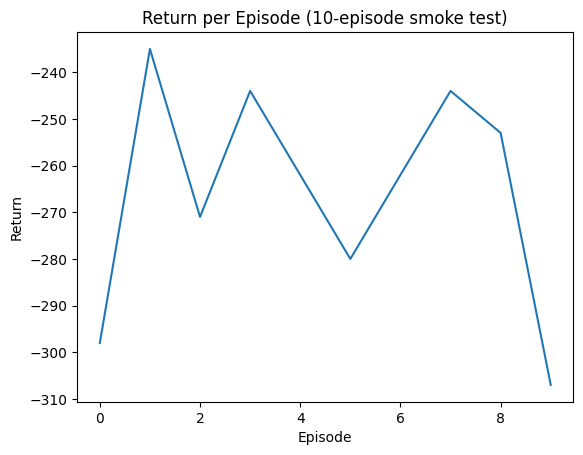

In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Make env
env = gym.make("Taxi-v3")

# Sizes
n_states = env.observation_space.n
n_actions = env.action_space.n
print("States:", n_states, "Actions:", n_actions)

# Quick 10-episode training so you see output immediately
base_cfg = QConfig(alpha=0.1, gamma=0.9, epsilon=0.1, episodes=10, max_steps=100)
agent = QAgent(n_states, n_actions, base_cfg)
returns, steps, ma = run_training(env, agent)

print("Episode returns:", returns)
print("Episode steps:  ", steps)
print("Final moving avg:", ma[-1])

# Quick plots (these should pop below the cell)
plt.figure()
plt.plot(returns)
plt.title("Return per Episode (10-episode smoke test)")
plt.xlabel("Episode"); plt.ylabel("Return")
plt.show()


### Step 3 — Training  with the base hyper-parameters

##### This code trains the Q-learning agent on the Taxi-v3 environment for 5000 episodes to improve its performance.  
##### It records rewards and steps per episode, then visualizes learning progress through plots of returns, steps, and moving average rewards.  
##### Overall, it shows how the agent learns better strategies over time.


Total episodes: 5000
Average steps/episode: 30.31
Average return/episode: -21.28


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128662 (\N{ONCOMING TAXI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


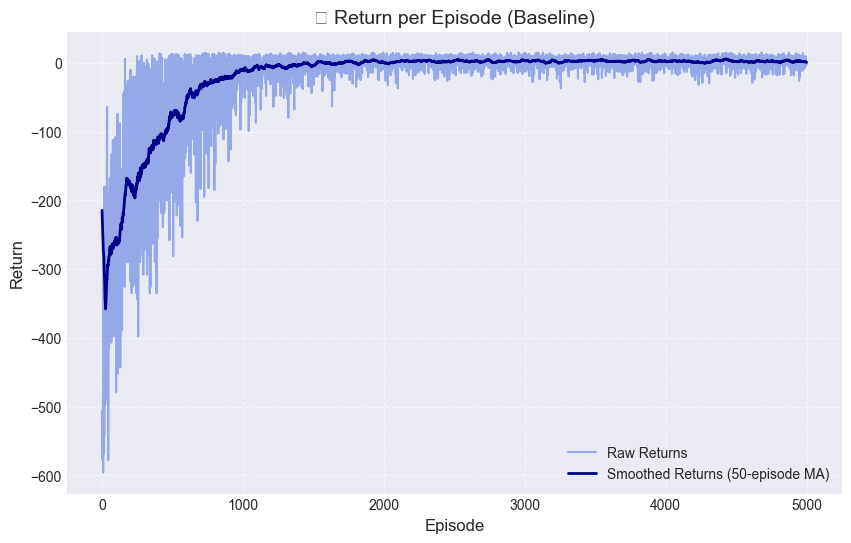

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129692 (\N{LADDER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


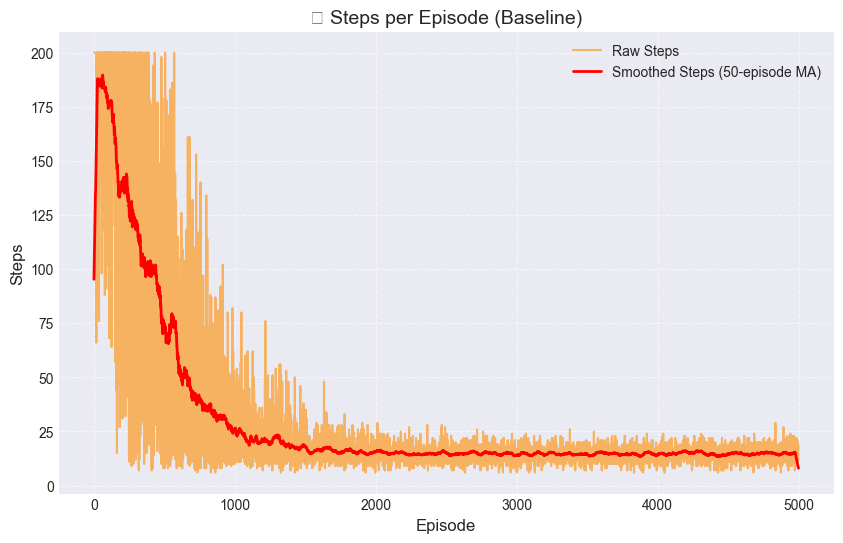

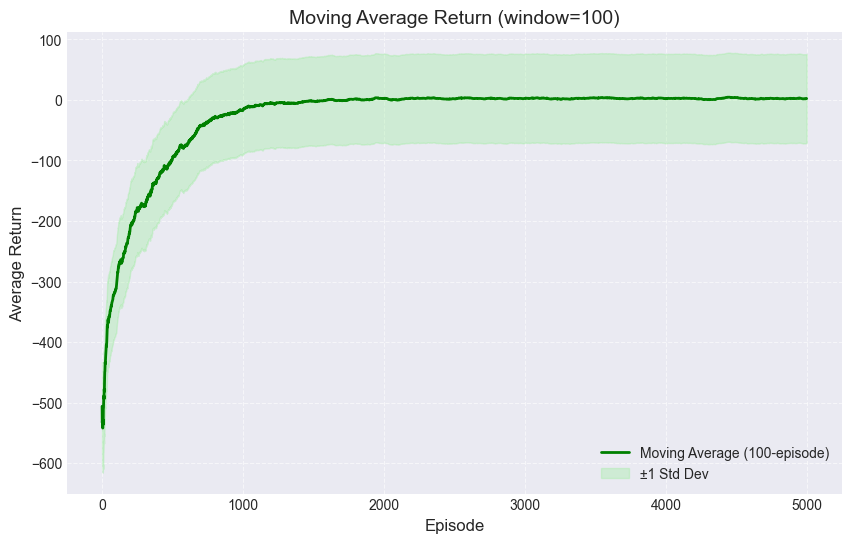

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Make env (no render during training; it's slow)
env = gym.make("Taxi-v3")

# Read sizes from env
n_states = env.observation_space.n
n_actions = env.action_space.n

# Assuming QConfig, QAgent, and run_training are defined elsewhere
base_cfg = QConfig(alpha=0.1, gamma=0.9, epsilon=0.1, episodes=5000, max_steps=200)
agent = QAgent(n_states, n_actions, base_cfg)
returns, steps, ma = run_training(env, agent)

print(f"Total episodes: {len(returns)}")
print(f"Average steps/episode: {sum(steps)/len(steps):.2f}")
print(f"Average return/episode: {sum(returns)/len(returns):.2f}")

# --- Visualization Improvements ---
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Helper: Smooth the curve
def smooth(y, box_pts=50):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Plot 1: Return per Episode
plt.figure()
plt.plot(returns, color='royalblue', alpha=0.5, label='Raw Returns')
plt.plot(smooth(returns, 50), color='darkblue', linewidth=2, label='Smoothed Returns (50-episode MA)')
plt.title("🚖 Return per Episode (Baseline)")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plot 2: Steps per Episode
plt.figure()
plt.plot(steps, color='darkorange', alpha=0.6, label='Raw Steps')
plt.plot(smooth(steps, 50), color='red', linewidth=2, label='Smoothed Steps (50-episode MA)')
plt.title("🪜 Steps per Episode (Baseline)")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plot 3: Moving Average Return
plt.figure()
plt.plot(ma, color='green', linewidth=2, label='Moving Average (100-episode)')
plt.fill_between(range(len(ma)), ma - np.std(ma), ma + np.std(ma), 
                 color='lightgreen', alpha=0.3, label='±1 Std Dev')
plt.title("Moving Average Return (window=100)")
plt.xlabel("Episode")
plt.ylabel("Average Return")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


### Step 4 — Training the Hyper-parameter experiments as required

#### Learning Rate α ∈ {0.01, 0.001, 0.2}

#### “Exploration Factor γ ∈ {0.2, 0.3}” — this looks like a small typo in the PDF: exploration is epsilon (ε), while γ denotes the discount factor. We’ll treat this as an exploration (ε) sweep of {0.2, 0.3}, keeping γ=0.9 as listed earlier. (You can also add a brief note in your report that you interpreted “exploration” as ε.)

#### Talking Points

- This code performs hyperparameter tuning by running multiple Q-learning experiments with different learning rates (α) and exploration rates (ε).  
- For each configuration, it trains the agent on the Taxi-v3 environment, collects rewards and steps, and summarizes performance metrics.  
- All results are stored in a pandas DataFrame for easy comparison and analysis of which parameter settings perform best.


In [9]:
from itertools import product
import numpy as np

def summarize_run(returns, steps):
    return {
        "episodes": len(returns),
        "avg_steps": float(np.mean(steps)),
        "avg_return": float(np.mean(returns)),
        "final_100_avg_return": float(np.mean(returns[-100:])),
    }

results = []

# 1) Learning rate sweep (epsilon fixed at 0.1)
for a in [0.01, 0.001, 0.2]:
    cfg = QConfig(alpha=a, gamma=0.9, epsilon=0.1, episodes=5000, max_steps=200)
    agent = QAgent(n_states, n_actions, cfg)
    r, s, ma = run_training(env, agent)
    summary = summarize_run(r, s)
    summary.update({"alpha": a, "epsilon": cfg.epsilon, "gamma": cfg.gamma, "kind":"alpha_sweep"})
    results.append(summary)

# 2) Exploration sweep (treating as epsilon sweep)
for eps in [0.2, 0.3]:
    cfg = QConfig(alpha=0.1, gamma=0.9, epsilon=eps, episodes=5000, max_steps=200)
    agent = QAgent(n_states, n_actions, cfg)
    r, s, ma = run_training(env, agent)
    summary = summarize_run(r, s)
    summary.update({"alpha": cfg.alpha, "epsilon": eps, "gamma": cfg.gamma, "kind":"epsilon_sweep"})
    results.append(summary)

import pandas as pd
df_results = pd.DataFrame(results)
df_results


,episodes,avg_steps,avg_return,final_100_avg_return,alpha,epsilon,gamma,kind
0,5000,127.3008,-160.6494,-63.88,0.010,0.1,0.9,alpha_sweep
1,5000,185.2130,-258.4208,-252.56,0.001,0.1,0.9,alpha_sweep
2,5000,23.5024,-11.4442,2.95,0.200,0.1,0.9,alpha_sweep
3,5000,32.6160,-32.4162,-6.19,0.100,0.2,0.9,epsilon_sweep
4,5000,36.1464,-47.4330,-13.00,0.100,0.3,0.9,epsilon_sweep
